In [1]:
import pandas as pd
import numpy as np
import os
from backtest import *
from process import *
from model import *

import lightgbm

# generate_data
# main()

## Split 1

n_groups:270,n_splits:1
group_test_starts:range(216, 270, 54)
group_train_starts:range(0, 54, 54)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106590
[LightGBM] [Info] Number of data points in the train set: 355445, number of used features: 418
[LightGBM] [Info] Start training from score -0.000000


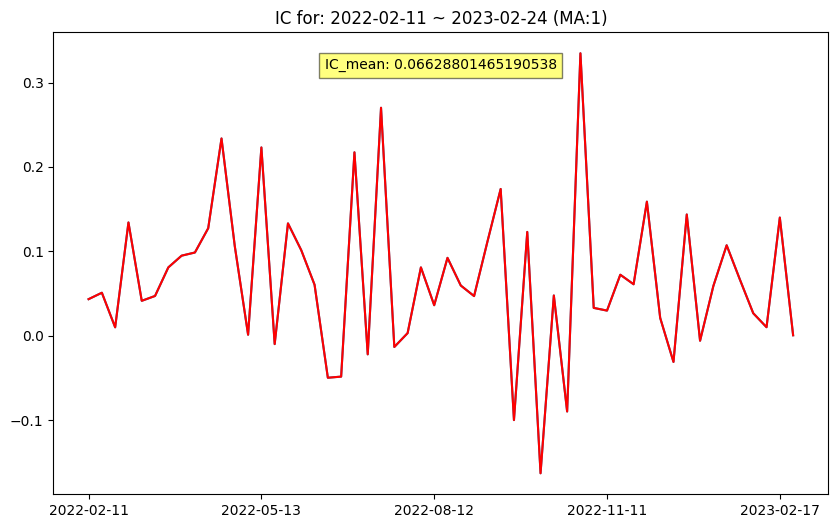

In [24]:
x = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_feature.npy')
y = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_label.npy',allow_pickle=True)
groups = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_index.npy',allow_pickle=True)
group = groups[:,1]

train_index, test_index = next(PurgedGroupTimeSeriesSplit(n_splits=2,group_gap=1).split_2(x,y,group,splits_minus=1))
x_train, x_test, y_train, y_test, group_train, group_test = x[train_index], x[test_index], y[train_index], y[test_index], group[train_index], group[test_index]

model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
y_pred = model.predict(x_test)

plot_ic(y_test,y_pred,group_test,continuous=True)

       Market_Value   Gross_Profit   fee_rate     return
count  5.300000e+01      53.000000  53.000000  53.000000
mean   4.310972e+06   -3839.194185   0.003473  -0.000610
std    1.544323e+05  152691.452423   0.000318   0.035113
min    3.930500e+06 -465193.618603   0.002682  -0.102391
25%    4.214150e+06  -80050.030678   0.003296  -0.018174
50%    4.305450e+06   -8512.048865   0.003445  -0.002013
75%    4.403740e+06   73029.004288   0.003666   0.017485
max    4.765400e+06  549227.914649   0.004166   0.128830


,單利,複利
年化收益,-0.031704,-0.061009
累计收益,-0.032314,-0.062145
最大回撤,0.171006,0.267978
夏普(r=4%),-0.285899,-0.402743
波动率,0.250802,0.250802
總交易周,53.000000,53.000000
凈獲利交易周,26.000000,26.000000
凈虧損交易周,27.000000,27.000000
勝率,0.490566,0.490566
周均凈收益,-0.000610,-0.001173


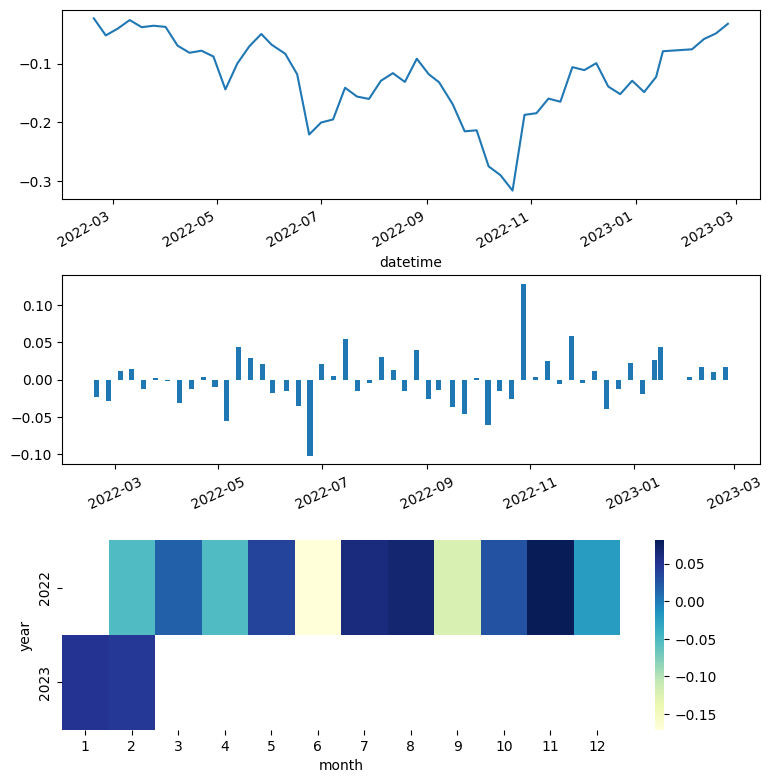

In [25]:
data = pd.read_pickle('/home/qianshuofu/Yansheng_strategy/data/initial_data/t_plus_max5_first_tradeday_adj_price.pkl')
industry = pd.read_csv('/home/qianshuofu/Yansheng_strategy/data/initial_data/industry_twse_tpex.csv')
adj_price = pd.read_feather('/home/qianshuofu/Yansheng_strategy/data/initial_data/adj_daily_TWSE_TPEX.ftr')
industry = process_industry(industry)
asset_pool = process_asset_pool(adj_price)

prediction = pd.DataFrame({'asset':groups[test_index,0],'datetime': pd.to_datetime(groups[test_index,1]),'pred':y_pred})
prediction['pred'] = prediction.groupby(['asset'])['pred'].shift(1)
prediction = prediction.dropna(subset=['pred']).set_index(['datetime','asset'])['pred']

capital, max_w = 500*10000, 0.04
holdings = get_holdings(prediction=prediction, data=data, industry=industry,
                        asset_pool=asset_pool, capital=capital, max_w=max_w)
analyze_risk_position_weekly(holdings, show_details=True)

## Split 5

n_groups:270,n_splits:5
group_test_starts:range(120, 270, 30)
group_train_starts:range(0, 150, 30)


<Axes: title={'center': 'PurgedGroupTimeSeriesSplit'}, xlabel='Sample index', ylabel='CV iteration'>

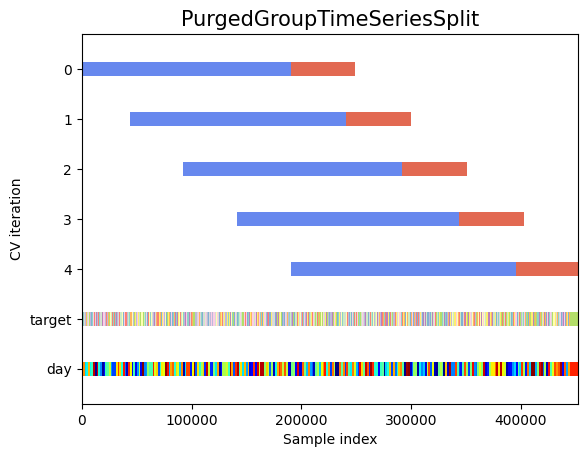

In [18]:
fig,ax = plt.subplots()
plot_cv_indices(PurgedGroupTimeSeriesSplit(n_splits=5,group_gap=1), x, y, group, ax, lw=10, split_method=False,splits_minus=0)

n_groups:270,n_splits:5
group_test_starts:range(120, 270, 30)
group_train_starts:range(0, 150, 30)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106334
[LightGBM] [Info] Number of data points in the train set: 192991, number of used features: 417
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21420
[LightGBM] [Info] Number of data points in the train set: 192991, number of used features: 84
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106335
[L

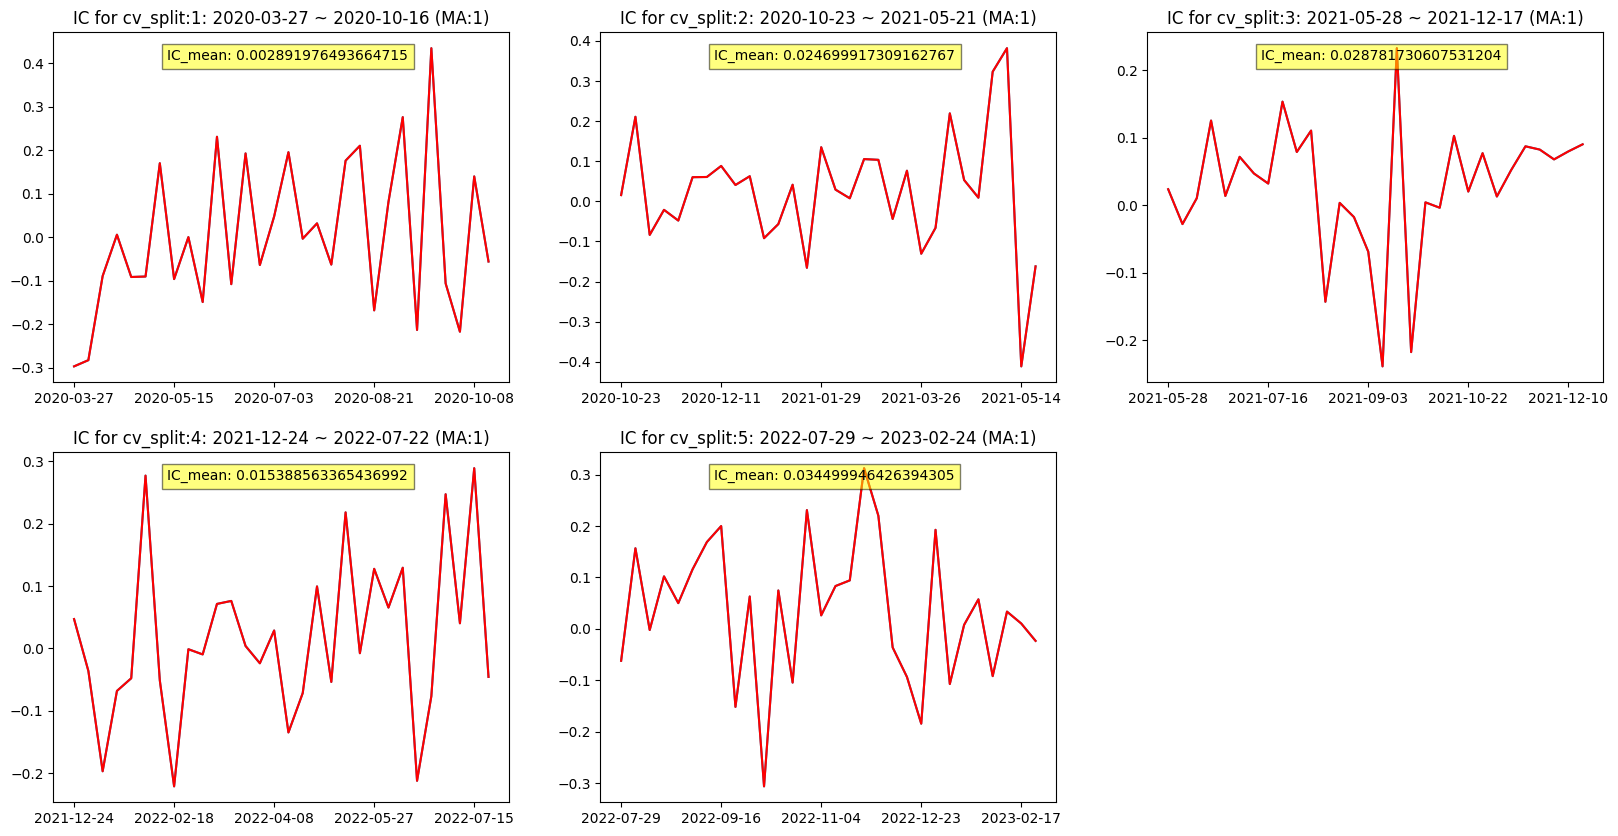

In [49]:
# main()

x = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_feature.npy')
y = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_label.npy',allow_pickle=True)
groups = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_index.npy',allow_pickle=True)
group = groups[:,1]

test_index_list = []
y_test_list = []
y_pred_list = []
group_list = []
cv = PurgedGroupTimeSeriesSplit(n_splits=5,group_gap=1).split_2(x,y,group)
for i, (tr,te) in enumerate(cv):
    x_train, x_test, y_train, y_test, group_train, group_test = x[tr], x[te], y[tr], y[te], group[tr], group[te]
    model1 = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
    feature_importance = model1.feature_importance()
    new_column = feature_importance.argsort().argsort() > len(feature_importance)*0.8
    x_train, x_test = x_train[:,new_column], x_test[:,new_column]
    model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))

    y_pred = model.predict(x_test)

    test_index_list.append(te)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    group_list.append(group_test)

plot_ic(y_test_list,y_pred_list,group_list)

       Market_Value  Gross_Profit    fee_rate      return
count  1.500000e+02  1.500000e+02  150.000000  150.000000
mean   4.282079e+06  2.948019e+05    0.003889    0.069359
std    1.843130e+05  3.612669e+05    0.000577    0.084092
min    3.682750e+06 -9.047725e+05    0.002191   -0.192617
25%    4.188775e+06  4.117605e+04    0.003492    0.009382
50%    4.295375e+06  2.307138e+05    0.003913    0.054314
75%    4.400915e+06  5.926222e+05    0.004273    0.138718
max    4.697250e+06  1.211641e+06    0.005177    0.275680


,單利,複利
年化收益,3.606649,26.864454
累计收益,10.403795,14736.200558
最大回撤,0.212566,0.208723
夏普(r=4%),5.901450,44.384287
波动率,0.604368,0.604368
總交易周,150.000000,150.000000
凈獲利交易周,117.000000,117.000000
凈虧損交易周,33.000000,33.000000
勝率,0.780000,0.780000
周均凈收益,0.069359,98.241337


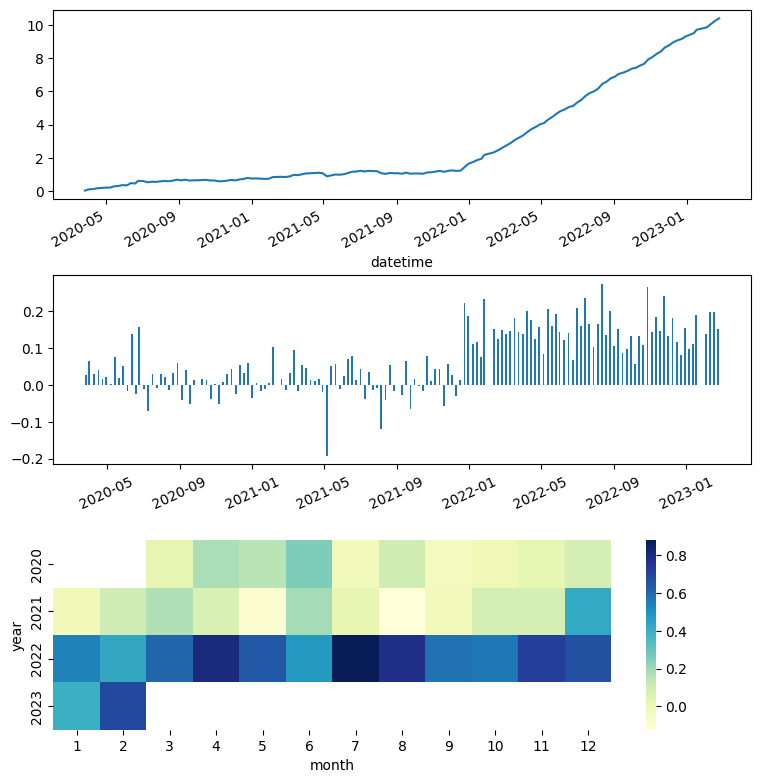

In [65]:
data = pd.read_pickle('/home/qianshuofu/Yansheng_strategy/data/initial_data/t_plus_max5_first_tradeday_adj_price.pkl')
industry = pd.read_csv('/home/qianshuofu/Yansheng_strategy/data/initial_data/industry_twse_tpex.csv')
adj_price = pd.read_feather('/home/qianshuofu/Yansheng_strategy/data/initial_data/adj_daily_TWSE_TPEX.ftr')
industry = process_industry(industry)
asset_pool = process_asset_pool(adj_price)

test_index = np.concatenate(test_index_list)

prediction = pd.DataFrame({'asset':groups[test_index,0],'datetime': pd.to_datetime(groups[test_index,1]),'pred':np.concatenate(y_pred_list)})
prediction = prediction.set_index(['datetime','asset'])['pred']

capital, max_w = 500*10000, 0.04
holdings = get_holdings(prediction=prediction, data=data, industry=industry,
                        asset_pool=asset_pool, capital=capital, max_w=max_w)
analyze_risk_position_weekly(holdings, show_details=True)

[Text(0.5, 0, 'y_pred'),
 Text(0, 0.5, 'y_true'),
 Text(0.5, 1.0, 'The mean y_true with y_pred group')]

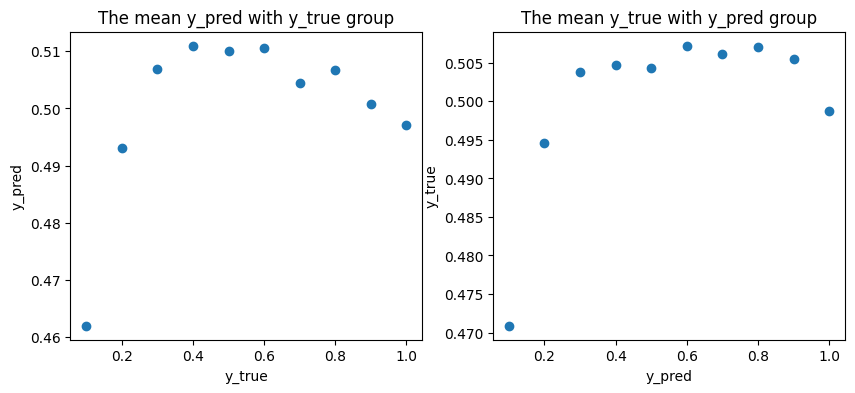

In [57]:
df = pd.DataFrame({'datetime':pd.to_datetime(groups[test_index,1]),"true":np.concatenate(y_test_list),'pred':np.concatenate(y_pred_list)})
df = df.groupby(['datetime']).rank(pct=True)
pred_list = []
true_list = []
for i in range(1,11):
    list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    pred_list.append(df[df.true<=list[i]][df.true>list[i-1]].pred.mean())
    true_list.append(df[df.pred<=list[i]][df.pred>list[i-1]].true.mean())

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.scatter(list[1:],pred_list)
# ax1.plot(list[1:],list[1:])
ax1.set(xlabel='y_true',ylabel='y_pred',title='The mean y_pred with y_true group')
ax2.scatter(list[1:],true_list)
# ax2.plot(list[1:],list[1:])
ax2.set(xlabel='y_pred',ylabel='y_true',title='The mean y_true with y_pred group')

#plt.scatter(df.true,df.pred,alpha=0.005)

## test

In [4]:
# 所有: 夏普:0.76, IC: 0.07,0.08
# 尝试修改y变为z_score, 夏普: 
# 尝试修改特征为mean, 夏普:  1.22
# 尝试修改特征为mean和std, 夏普: 0.46 IC:0.05,0.06
# 尝试特征去最后一个, 夏普:0.64 IC:0.08,0.09

# last:
# 线性模型: 夏普:1.09, IC:0.09
# ridge: 夏普:1.21, IC:0.1
# lasso: xiapu:0.56, IC:0

# last y_norm
# ridge: 1.27

# all
# ridge: 夏普:0.98, IC:0.08

# mean,std
# ridge: 夏普:0.92, IC: 0.08

# mean y_norm
# ridge 1.04



In [10]:
feature = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_feature.npy')
label = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_label.npy',allow_pickle=True)[:,np.newaxis]
index = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_index.npy',allow_pickle=True)
columns = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_columns.npy',allow_pickle=True)

df = pd.DataFrame(np.concatenate([index,feature,label],axis=1),columns=columns)

# df_ic = pd.DataFrame({'column_name':df.columns[2:-1],'ic':[np.mean(calculate_ic(df[i],df['return'],df['datetime'])[1]) for i in df.columns[2:-1]]})

       Market_Value   Gross_Profit    fee_rate      return
count  1.500000e+02     150.000000  150.000000  150.000000
mean   4.189187e+06   35716.292091    0.001954    0.008422
std    1.796113e+05  172043.841348    0.000407    0.040642
min    3.530800e+06 -699369.614418    0.001034   -0.163985
25%    4.061662e+06  -69792.132884    0.001682   -0.016940
50%    4.201495e+06   33640.142387    0.001957    0.008094
75%    4.309280e+06  150976.107538    0.002190    0.036008
max    4.650870e+06  455799.715012    0.004137    0.104997


,單利,複利
年化收益,0.437931,0.482131
累计收益,1.263263,2.111299
最大回撤,0.204910,0.278153
夏普(r=4%),1.362332,1.513650
波动率,0.292096,0.292096
總交易周,150.000000,150.000000
凈獲利交易周,84.000000,84.000000
凈虧損交易周,66.000000,66.000000
勝率,0.560000,0.560000
周均凈收益,0.008422,0.014075


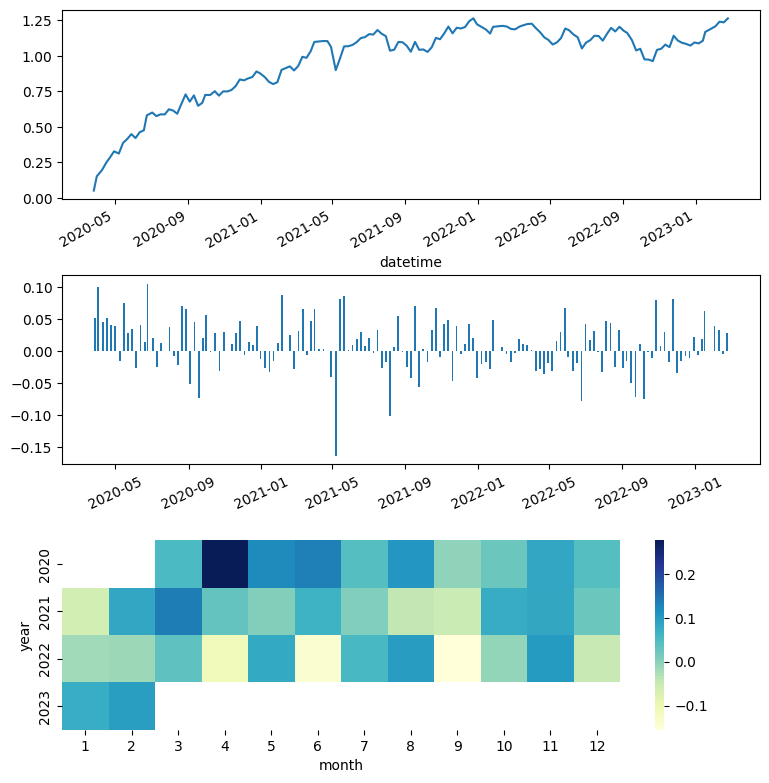

In [19]:
df['datetime'] = pd.to_datetime(df['datetime'])
tmp = df.set_index(['datetime','asset'])['mid_sub_small_ratio_share_diff4w_mean'].iloc[test_index].rename('pred')
holdings = get_holdings(prediction=tmp, data=data, industry=industry,
                        asset_pool=asset_pool, capital=capital, max_w=max_w)
analyze_risk_position_weekly(holdings, show_details=True)

n_groups:270,n_splits:5
group_test_starts:range(120, 270, 30)
group_train_starts:range(0, 150, 30)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 192991, number of used features: 50
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 195624, number of used features: 50
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[Ligh

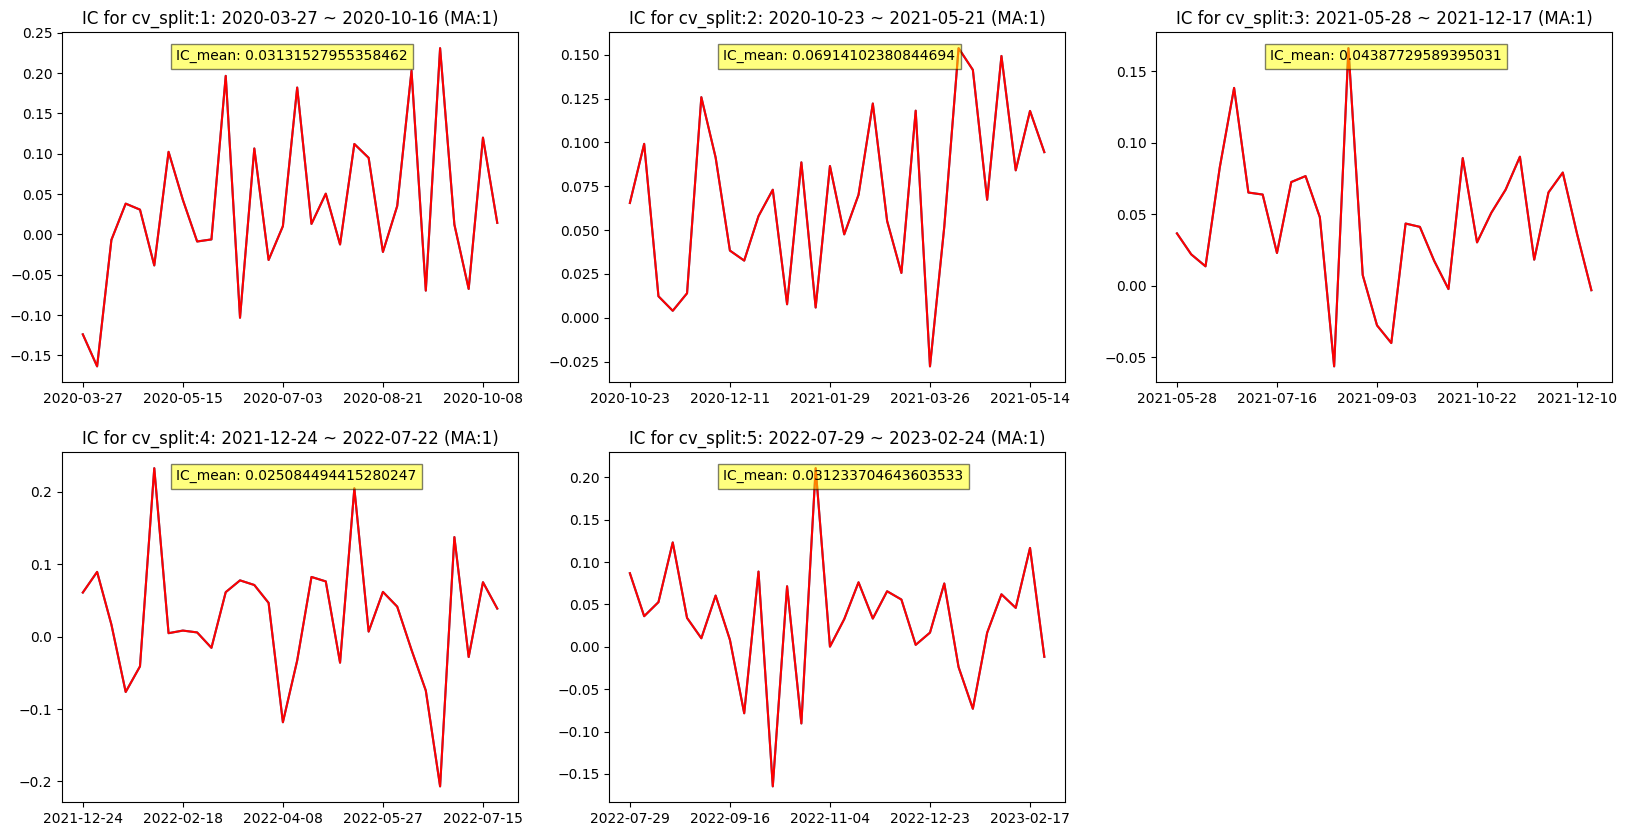

In [74]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.decomposition import PCA

# main()

x = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_feature.npy')
y = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_label.npy',allow_pickle=True)
groups = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_index.npy',allow_pickle=True)
group = groups[:,1]

test_index_list = []
y_test_list = []
y_pred_list = []
group_list = []
cv = PurgedGroupTimeSeriesSplit(n_splits=5,group_gap=1).split_2(x,y,group)
for i, (tr,te) in enumerate(cv):
    x_train, x_test, y_train, y_test, group_train, group_test = x[tr], x[te], y[tr], y[te], group[tr], group[te]
    pca = PCA(n_components=50).fit(x_train)
    x_train, x_test = pca.transform(x_train), pca.transform(x_test)
    
    model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
    y_pred = model.predict(x_test)

    test_index_list.append(te)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    group_list.append(group_test)

plot_ic(y_test_list,y_pred_list,group_list)

       Market_Value   Gross_Profit    fee_rate      return
count  1.500000e+02     150.000000  150.000000  150.000000
mean   4.348287e+06   40211.461918    0.003504    0.009483
std    1.724686e+05  201352.898352    0.000335    0.046813
min    3.713150e+06 -914936.414394    0.002778   -0.216838
25%    4.233630e+06  -80341.957052    0.003291   -0.018444
50%    4.354335e+06   43502.515458    0.003484    0.009920
75%    4.479610e+06  141861.704166    0.003688    0.032513
max    4.725000e+06  593578.757596    0.004597    0.144146


,單利,複利
年化收益,0.493142,0.543709
累计收益,1.422525,2.498958
最大回撤,0.247233,0.306996
夏普(r=4%),1.346842,1.497139
波动率,0.336448,0.336448
總交易周,150.000000,150.000000
凈獲利交易周,90.000000,90.000000
凈虧損交易周,60.000000,60.000000
勝率,0.600000,0.600000
周均凈收益,0.009483,0.016660


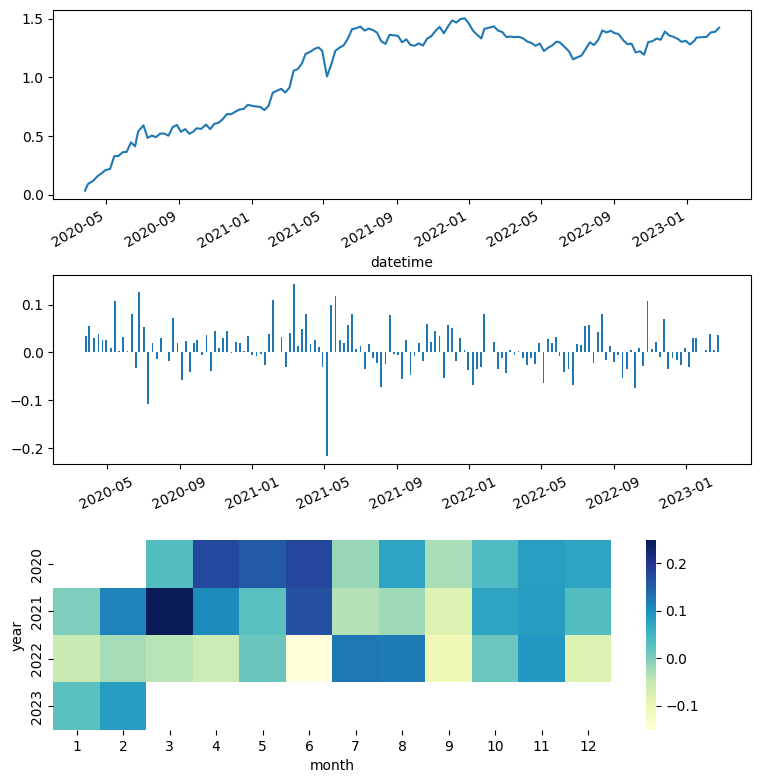

In [75]:
data = pd.read_pickle('/home/qianshuofu/Yansheng_strategy/data/initial_data/t_plus_max5_first_tradeday_adj_price.pkl')
industry = pd.read_csv('/home/qianshuofu/Yansheng_strategy/data/initial_data/industry_twse_tpex.csv')
adj_price = pd.read_feather('/home/qianshuofu/Yansheng_strategy/data/initial_data/adj_daily_TWSE_TPEX.ftr')
industry = process_industry(industry)
asset_pool = process_asset_pool(adj_price)

test_index = np.concatenate(test_index_list)

prediction = pd.DataFrame({'asset':groups[test_index,0],'datetime': pd.to_datetime(groups[test_index,1]),'pred':np.concatenate(y_pred_list)})
prediction = prediction.set_index(['datetime','asset'])['pred']

capital, max_w = 500*10000, 0.04
holdings = get_holdings(prediction=prediction, data=data, industry=industry,
                        asset_pool=asset_pool, capital=capital, max_w=max_w)
analyze_risk_position_weekly(holdings, show_details=True)